In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly as py
import plotly.graph_objs as go

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
import os
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

In [2]:
retail = pd.read_csv("Online Retail.csv")

In [3]:
retail = retail.dropna()

In [4]:
retail = retail[(retail['Country']=='United Kingdom') & (retail['Quantity'] > 0)]

In [5]:
retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m

CustomerID    Amount
0        12346.0  77183.60
1        12747.0   4196.01
2        12748.0  33719.73
3        12749.0   4090.88
4        12820.0    942.34
...          ...       ...
3916     18280.0    180.60
3917     18281.0     80.82
3918     18282.0    178.05
3919     18283.0   2094.88
3920     18287.0   1837.28

[3921 rows x 2 columns]

In [6]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].nunique()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head(20)

CustomerID  Frequency
0      12346.0          1
1      12747.0         11
2      12748.0        210
3      12749.0          5
4      12820.0          4
5      12821.0          1
6      12822.0          2
7      12823.0          5
8      12824.0          1
9      12826.0          7
10     12827.0          3
11     12828.0          6
12     12829.0          2
13     12830.0          6
14     12831.0          1
15     12832.0          2
16     12833.0          1
17     12834.0          1
18     12836.0          4
19     12837.0          1

In [7]:
# Merging the two dfs

rfm = pd.merge(rfm_m,rfm_f,how='inner',on='CustomerID')
rfm.head()

CustomerID    Amount  Frequency
0     12346.0  77183.60          1
1     12747.0   4196.01         11
2     12748.0  33719.73        210
3     12749.0   4090.88          5
4     12820.0    942.34          4

In [8]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d/%m/%Y %H:%M')
# Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:49:00')

In [9]:
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Amount  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom   15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom   22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   20.34   

               Diff  
0 373 days 04:23:00  
1 373 days 04:23:00  
2 373 days 04:23:00  
3 373 days 04:23:00  
4 373 days 04:23:00

In [10]:
rfm_r = retail.groupby('CustomerID')['Diff'].min()
rfm_r = rfm_r.reset_index()

rfm_r

CustomerID              Diff
0        12346.0 325 days 02:48:00
1        12747.0   1 days 22:15:00
2        12748.0   0 days 00:29:00
3        12749.0   3 days 02:53:00
4        12820.0   2 days 21:37:00
...          ...               ...
3916     18280.0 277 days 02:57:00
3917     18281.0 180 days 01:56:00
3918     18282.0   7 days 01:06:00
3919     18283.0   3 days 00:47:00
3920     18287.0  42 days 03:20:00

[3921 rows x 2 columns]

In [11]:
rfm_r['Diff'] = rfm_r['Diff'].dt.days
rfm_r

CustomerID  Diff
0        12346.0   325
1        12747.0     1
2        12748.0     0
3        12749.0     3
4        12820.0     2
...          ...   ...
3916     18280.0   277
3917     18281.0   180
3918     18282.0     7
3919     18283.0     3
3920     18287.0    42

[3921 rows x 2 columns]

In [12]:
rfm = pd.merge(rfm,rfm_r,how='inner', on='CustomerID')
rfm = rfm.rename({'Diff':'Recency'},axis='columns')
rfm

CustomerID    Amount  Frequency  Recency
0        12346.0  77183.60          1      325
1        12747.0   4196.01         11        1
2        12748.0  33719.73        210        0
3        12749.0   4090.88          5        3
4        12820.0    942.34          4        2
...          ...       ...        ...      ...
3916     18280.0    180.60          1      277
3917     18281.0     80.82          1      180
3918     18282.0    178.05          2        7
3919     18283.0   2094.88         16        3
3920     18287.0   1837.28          3       42

[3921 rows x 4 columns]

In [13]:
# rfm.to_csv('rfm.csv',index=False)

In [15]:
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]
rfm_df

Amount  Frequency  Recency
0     77183.60          1      325
1      4196.01         11        1
2     33719.73        210        0
3      4090.88          5        3
4       942.34          4        2
...        ...        ...      ...
3916    180.60          1      277
3917     80.82          1      180
3918    178.05          2        7
3919   2094.88         16        3
3920   1837.28          3       42

[3921 rows x 3 columns]

In [16]:
inertia = []
for n in range(1 , 11):
    algorithm = KMeans(n_clusters = n  ,max_iter=50)
    algorithm.fit(rfm_df)
    inertia.append(algorithm.inertia_)

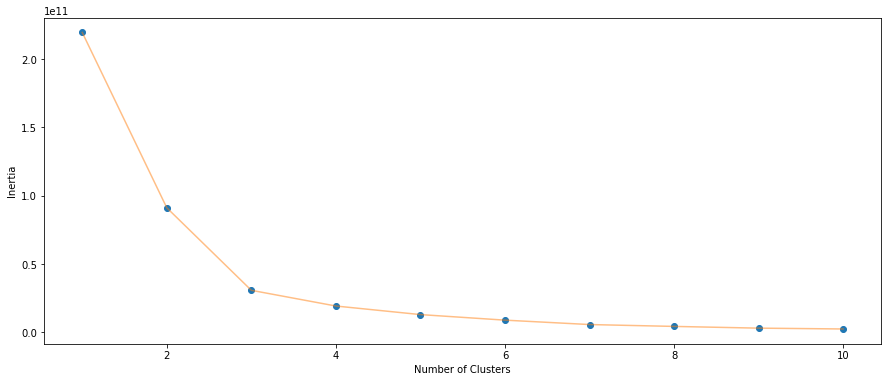

In [19]:

plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [22]:
algorithm = KMeans(n_clusters=3, max_iter=50)
algorithm.fit(rfm_df)


KMeans(max_iter=50, n_clusters=3)

In [25]:
algorithm.labels_
labels3 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [26]:
#Amount	Frequency	Recency

rfm['labels3'] =  labels3
trace1 = go.Scatter3d(
    x= rfm['Amount'],
    y= rfm['Frequency'],
    z= rfm['Recency'],
    mode='markers',
     marker=dict(
        color = rfm['labels3'], 
        size= 20,
        line=dict(
            color= rfm['labels3'],
            width= 12
        ),
        opacity=0.8
     )
)
data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Amount'),
            yaxis = dict(title  = 'Frequency'),
            zaxis = dict(title  = 'Recency')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [27]:
rfm.groupby('labels3')['labels3'].count()

labels3
0    3888
1       3
2      30
Name: labels3, dtype: int64